# PROJET 5 : CREATION DE TAGG POUR LES QUESTIONS DE STAKEOVERFLOW

## PARTIE 3 : entrainer les modèles qui vont prédire les tags
- le LDIA : algorythme de classification non supérvisé qui regroupe les textes par thème avec une petite liste de mots
- most common word : algorythme qui fait la liste des mots les plus courant
- quelques algorythme de classification supervisée

https://keras.io/examples/nlp/

## PARTIE 4 : représenter les résultats sous forme d'une API
- API : développer un modèle dvp sur un serveur, si on envoie le modèle à tel adresse 
api "resfull api" de flask : https://flask-restful.readthedocs.io/en/latest/ 
fast api

- mettre le code sur github

In [61]:
#!pip install nltk
#!pip install bs4 
#!pip install wordcloud
#!pip install ipynb

In [84]:
# liste des bibliothèques utiles dans ce script
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import re 
import time
from datetime import datetime
import numpy as np

from collections import Counter
from string import punctuation
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import nltk

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score, jaccard_score, hamming_loss, confusion_matrix, make_scorer
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import svm

import ipynb
#from ipynb.fs.full.Projet5_analyse_exploratoire import nettoyage_text

# Intro : Récupération des données de Stackoverflow

In [85]:
data = pd.read_csv('data.csv')
dfT = pd.read_csv('tags.csv')

# Methode 1 : simple
- Méthode sans classification qui proposer juste les mots les plus courant du titre

In [86]:
def most_com(text):  
    words=nettoyage_text(text)
    most_common_words= [word for word, word_count in Counter(words).most_common(3)]
    return " ".join(most_common_words)
#note : fonction testée sur le script d'analyse exploratoire car l'import des fichiers de type ipynb est toujours compliqué

In [20]:
text  = """
Python: Add text to step plot
Python: Add text to step plot
Python: Add text to step plot
Say that I am plotting a very basic step plot with this code:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4, 5, 6] 
y = [0.5, 0.22, 0.75, 1, 0.9, 1.2]
text = ['H', 'F', 'E', 'F', 'IT', 'M']
plt.step(x, y,'k-', where='post')
plt.show()
enter image description here
How can I display on the top of each lines or bar, the text list? So between x=1 and x=2 on the top of the bar, have 'H', then between x=2 and x=3, have 'F', and so on...
"""
text_tags = most_com(text)
print(text_tags)

# Méthode 2 : Classification

### CLASSIFICATION CLASSIQUE

In [87]:
X = data['question']
y = data['Tag']

def tokenize(text): # passe de text à liste de mots
    token=ToktokTokenizer()
    words = token.tokenize(text)
    return words
y_list = data['Tag'].apply(tokenize)

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y_list)

vectorizer_X1 = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False,
                             ngram_range=(1,4))

vectorizer_X = TfidfVectorizer(analyzer = 'word',
                               min_df=0.0,
                               max_df = 1.0,
                               strip_accents = None,
                               encoding = 'utf-8', 
                               preprocessor=None,
                               token_pattern=r'\w{1,}',
                               ngram_range=(1, 1),  # features made of a single tokens
                               use_idf=True,  # enable inverse-document-frequency reweighting
                               smooth_idf=True,
                               max_features=1000)

X_tfidf = vectorizer_X.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) 

print("Training data : X_train ({}) / y_train ({})".format(X_train.shape, y_train.shape))
print("Test data : X_test ({}) / y_test ({})".format(X_test.shape, y_test.shape))

Training data : X_train ((2706, 1000)) / y_train ((2706, 20))
Test data : X_test ((677, 1000)) / y_test ((677, 20))


In [88]:
feature_names = vectorizer_X.get_feature_names()
print(multilabel_binarizer.classes_)
#print(feature_names[0:10])
#print(np.argsort(clf.coef_[i])[-10:])

['.net' 'asp.net' 'c' 'c#' 'c++' 'database' 'html' 'java' 'javascript'
 'language-agnostic' 'mysql' 'performance' 'php' 'python' 'sql'
 'sql-server' 'svn' 'visual-studio' 'windows' 'xml']


## Recherche du meilleurs classifieur

In [89]:
def print_score(y_pred, clf, df_score, time=0):
    #print("Clf: ", clf.__class__.__name__)
    #print("Jacard score avg: {}".format(jaccard_score(y_test, y_pred, average='samples')))
    #print("Jacard score macro: {}".format(jaccard_score(y_test, y_pred, average='macro')))
    #print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)))
    #print("Time :", time)
    #print("---") 
    df_score = df_score.append({'Classifier':clf.__class__.__name__,
                                'Jacard_avg':jaccard_score(y_test, y_pred, average='samples'),
                                'Jacard_macro':jaccard_score(y_test, y_pred, average='macro'),
                                'Hamming': hamming_loss(y_pred, y_test),
                                "Accuracy":metrics.accuracy_score(y_test, y_pred),
                                'Recall':recall_score(y_test, y_pred, average='macro'),
                                'precision':precision_score(y_test, y_pred, average='macro'),
                                'Time':time,
                                'f1':f1_score(y_test, y_pred, average='micro')
                               },ignore_index=True)
    #print (metrics.classification_report(y_test, y_pred))
    #print(df_score.shape)
    return df_score

def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label," ".join(feature_names[j] for j in top10)))
        

#'micro' / 'macro' / 'sample'

In [90]:
df_score = pd.DataFrame(columns = ['Classifier', 'Jacard_avg', 'Jacard_macro', 'Hamming',
                                   'Accuracy','Recall', 'precision','Time'])

dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

print(multilabel_binarizer.classes_)
feature_names = vectorizer_X.get_feature_names()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    start = datetime.now()
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    t = datetime.now() - start  
    df_score = print_score(y_pred, clf, df_score, t)
    
    #print_top10(feature_names, clf, multilabel_binarizer.classes_)
    #print('ok')


    
start = datetime.now()
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)
y_pred = mlpc.predict(X_test)
t = datetime.now() - start
df_score = print_score(y_pred, mlpc, df_score, t)

start = datetime.now()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
t = datetime.now() - start
df_score = print_score(y_pred, rfc, df_score, t) 


df_score.head(10)

['.net' 'asp.net' 'c' 'c#' 'c++' 'database' 'html' 'java' 'javascript'
 'language-agnostic' 'mysql' 'performance' 'php' 'python' 'sql'
 'sql-server' 'svn' 'visual-studio' 'windows' 'xml']


,Classifier,Jacard_avg,Jacard_macro,Hamming,Accuracy,Recall,precision,Time,f1
0,OneVsRestClassifier,0.056869,0.033626,0.118464,0.019202,0.063281,0.066701,0 days 00:00:00.014000,0.091733
1,OneVsRestClassifier,0.490768,0.437357,0.046160,0.378139,0.500795,0.735311,0 days 00:00:00.100255,0.590701
2,OneVsRestClassifier,0.306499,0.265480,0.050000,0.246677,0.273912,0.761635,0 days 00:00:00.416279,0.437240
3,OneVsRestClassifier,0.074594,0.062647,0.062482,0.059084,0.063370,0.552440,0 days 00:00:00.032827,0.126033
4,OneVsRestClassifier,0.478213,0.433457,0.044165,0.375185,0.474217,0.807990,0 days 00:00:00.125328,0.589849
5,OneVsRestClassifier,0.453520,0.392580,0.059158,0.299852,0.523915,0.580206,0 days 00:00:00.062740,0.538860
6,OneVsRestClassifier,0.445347,0.403859,0.060192,0.289513,0.526353,0.593630,0 days 00:00:00.136201,0.532415
7,MLPClassifier,0.447686,0.397536,0.051773,0.329394,0.459491,0.714335,0 days 00:00:13.076514,0.545690
8,RandomForestClassifier,0.387740,0.298162,0.046603,0.326440,0.309289,0.801259,0 days 00:00:03.391463,0.495604


In [91]:
def avg_jacard(y_true,y_pred):
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    return jacard.mean()*100

param_grid = {'estimator__C':[1,10,100,1000]}
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, 
                                      param_grid=param_grid, 
                                      cv= 5, verbose=10, 
                                      scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................
[CV] ..................... estimator__C=1, score=46.248, total=   0.1s
[CV] estimator__C=1 ..................................................
[CV] ..................... estimator__C=1, score=45.949, total=   0.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... estimator__C=1, score=49.868, total=   0.1s
[CV] estimator__C=1 ..................................................
[CV] ..................... estimator__C=1, score=45.933, total=   0.1s
[CV] estimator__C=1 ..................................................
[CV] ..................... estimator__C=1, score=48.891, total=   0.1s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


[CV] .................... estimator__C=10, score=45.680, total=   0.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s


[CV] .................... estimator__C=10, score=44.301, total=   0.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


[CV] .................... estimator__C=10, score=47.927, total=   0.2s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s


[CV] .................... estimator__C=10, score=43.654, total=   0.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s


[CV] .................... estimator__C=10, score=49.298, total=   0.2s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=44.081, total=   0.4s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=43.207, total=   0.4s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=46.362, total=   0.4s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=40.632, total=   0.4s
[CV] estimator__C=100 ................................................
[CV] ................... estimator__C=100, score=46.617, total=   0.4s
[CV] estimator__C=1000 ...............................................
[CV] .................. estimator__C=1000, score=44.096, total=   0.4s
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 10, 100, 1000]},
             scoring=make_scorer(avg_jacard), verbose=10)

In [92]:
df_scoreBM = pd.DataFrame(columns = ['Classifier', 'Jacard_avg', 'Jacard_macro', 'Hamming',
                                   'Accuracy','Recall', 'precision','Time'])
CV_svc.best_params_
best_model = CV_svc.best_estimator_
y_pred = best_model.predict(X_test)
print(best_model)
df_scoreBM = print_score(y_pred, best_model, df_scoreBM)

OneVsRestClassifier(estimator=LinearSVC(C=1))


In [93]:
df_scoreBM.head()

,Classifier,Jacard_avg,Jacard_macro,Hamming,Accuracy,Recall,precision,Time,f1
0,OneVsRestClassifier,0.478213,0.433457,0.044165,0.375185,0.474217,0.80799,0,0.589849


In [94]:
feature_names = vectorizer_X.get_feature_names()
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

.net: assemblies via automate vista native false generic wcf assembly net
asp.net: side control prevent postback page cache webconfig cause web asp
c: level include b warn gcc platform c char printf cc
c#: linq reference way compact namespace lock datatable foreach core c
c++: certain gcc bool 64 j const win32 c cc std
database: iterate join trick transaction language record past databases db database
html: font browsers tag put site inline give width div html
java: alternatives happen api application distribute action dependency javadoc eclipse java
javascript: ajax function browser js virtual side ie var jquery javascript
language-agnostic: statement last similar prefer regex function non ways based language
mysql: integration live order support entry statements 3 query limit mysql
performance: scale time measure sense efficient fastest faster optimize speed performance
php: pass post specific resize entry integration session permissions apache php
python: x thing plug iterate drag n

In [95]:
# on regarde aussi les résultat de la matrice de confusion (il faut que l'élément en haut à gauche soit plus élevé que les autres)

for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))

.net
[[532  28]
 [ 60  57]]
asp.net
[[599   7]
 [ 27  44]]
c
[[660   0]
 [ 13   4]]
c#
[[503  40]
 [ 88  46]]
c++
[[639   2]
 [ 27   9]]
database
[[623   9]
 [ 31  14]]
html
[[651   5]
 [ 14   7]]
java
[[612   2]
 [ 28  35]]
javascript
[[644   1]
 [ 13  19]]
language-agnostic
[[649   2]
 [ 19   7]]
mysql
[[655   2]
 [  7  13]]
performance
[[655   2]
 [ 15   5]]
php
[[633   1]
 [ 18  25]]
python
[[640   1]
 [ 14  22]]
sql
[[630  11]
 [ 20  16]]
sql-server
[[604   6]
 [ 24  43]]
svn
[[648   0]
 [  6  23]]
visual-studio
[[635   4]
 [ 21  17]]
windows
[[642   5]
 [ 18  12]]
xml
[[658   1]
 [  6  12]]


### LDA classifier

LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output.

There are 3 main parameters of the model:
- the number of topics
- the number of words per topic
- the number of topics per document

In reality, the last two parameters are not exactly designed like this in the algorithm, but I prefer to stick to these simplified versions which are easier to understand.

In [96]:
X = data['question']
y = data['Tag']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

vectorizer_X = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

X_tfidf = vectorizer_X.fit_transform(X)

nbr_topics = 20
lda = LatentDirichletAllocation(n_components=nbr_topics, 
                                max_iter = 5, 
                                learning_method = 'online', 
                                learning_offset = 50,
                                random_state = 11)
X_lda = lda.fit_transform(X_tfidf)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_bin, test_size = 0.2, random_state = 0)

In [97]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_X.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
press button submit form window key input win32 -- xml
--------------------------------------------
--------------------------------------------
Topic 1:
use file sql server database way windows table asp.net application
--------------------------------------------
--------------------------------------------
Topic 2:
performance color method group setup mysql csv database class best
--------------------------------------------
--------------------------------------------
Topic 3:
ip address resolve domain name java javascript create subversion php
--------------------------------------------
--------------------------------------------
Topic 4:
test control use 124 unit textbox visual class studio integration
--------------------------------------------
--------------------------------------------
Topic 5:
email oracle folders binary user amp connect project mysql mark
--------------------------------------------
------------------

In [57]:
# la recherche de tags ne fonctionne pas avec cette méthode d'implémentation de la LDA, je vais donc en essayer une autre

In [98]:
#!pip install gensim
from gensim import models
from gensim.models import Phrases
from gensim import corpora

In [99]:
tokens = data['question'].apply(nltk.word_tokenize) #.tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [100]:
print(tokens[0:2])
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

[['convert_decimal', 'double', 'c_#', 'convert_decimal', 'double', 'c_#', 'convert_decimal', 'double', 'c_#', 'want', 'use', 'track-bar', 'change', 'form', 'opacity', 'code', 'decimal', 'trans', 'trackbar1value', '5000', 'thisopacity', 'trans', 'build', 'application', 'give_follow_error', 'can_not_implicitly', 'convert', 'type', 'decimal_double', 'try', 'use', 'trans', 'double', 'control', 'work', 'code', 'work_fine', 'past', 'vb.net', 'project'], ['width_collapse', 'percentage_width_child', 'element_absolutely_position', 'parent_internet_explorer', '7_width', 'collapse_percentage', 'width_child_element', 'absolutely_position_parent', 'internet_explorer_7', 'width_collapse', 'percentage_width_child', 'element_absolutely_position', 'parent_internet_explorer', '7', 'absolutely_position_div', 'contain', 'several', 'children', 'one', 'relatively', 'position_div', 'use', 'percentage-based', 'width_child', 'div', 'collapse', '0', 'width_ie7', 'firefox_safari', 'use', 'pixel', 'width', 'work'

In [79]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


In [101]:
np.random.seed(123456)
num_topics = 20
#corpus = data['question']
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 8.14 s


In [102]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=5):
    print(str(i)+": "+ topic)
    print()

0: 0.033*"file" + 0.021*"image" + 0.017*"get" + 0.014*"path" + 0.014*"2005"

1: 0.036*"python" + 0.019*"program" + 0.016*"would" + 0.014*"database" + 0.010*"get"

2: 0.017*"1" + 0.014*"c_#" + 0.014*"code" + 0.013*"read" + 0.013*"0"

3: 0.045*"project" + 0.018*"build" + 0.017*".net" + 0.017*"-" + 0.015*"name"

4: 0.029*"project" + 0.022*"page" + 0.021*"function" + 0.013*"task" + 0.012*"create"

5: 0.023*"tag" + 0.021*"get" + 0.019*"page" + 0.011*"value" + 0.010*"one"

6: 0.040*"java" + 0.018*"way" + 0.015*"file" + 0.013*"version" + 0.012*"get"

7: 0.024*"php" + 0.022*"sql_server" + 0.021*"search" + 0.017*"c_#" + 0.015*"-"

8: 0.023*"file" + 0.011*"code" + 0.010*"server" + 0.009*"one" + 0.009*"run"

9: 0.050*"library" + 0.049*".net" + 0.044*"c_#" + 0.043*"method" + 0.036*"--_--_--_--"

10: 0.018*"data" + 0.011*"table" + 0.011*"database" + 0.010*"create" + 0.010*"query"

11: 0.016*"get" + 0.012*"work" + 0.011*"value" + 0.009*"code" + 0.008*"application"

12: 0.025*"object" + 0.023*"list" 

In [103]:
document = data['question'][10]

np.random.seed(123456)
num_topics = 20
lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

def recherche_tag_lda(lda_model, document):
    print(document)

    tokens = word_tokenize(document)
    topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10)
    doc = pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) \
                  for el in lda_model[dictionary_LDA.doc2bow(tokens)]],\
                 columns=['topic #', 'weight', 'words in topic'])
    doc = doc[doc['weight']== max(doc['weight'])]['words in topic']
    
    #mise en forme des tags
    doc = doc.values[0]
    doc = doc.replace('"',' ')
    doc = doc.replace('*','')
    doc = doc.replace(' + ','')
    #table = str.maketrans('','',digits)
    #doc = doc.translate(table)
    doc = doc.replace('. ','')
    doc = re.split(' ',doc)
    return doc


doc = recherche_tag_lda(lda_model, document)
print(doc)

use c socket api c++ zos use c socket api c++ zos use c socket api c++ zos issue get c sockets api work properly c++ zos although include syssocketh still get compile time errors tell afinet define miss something obvious relate fact zos make problems much complicate discover ifdef hit apparently zos happy unless define type sockets use define oesockets personally idea oesockets actually zos sockets programmers 3 perhaps could give rundown work test app include syssocketh int main return afinet compilelink output cxx -wc xplink -wl xplink -o inettest inetc inetc line 516 ccn5274 name lookup afinet find declaration ccn0797 compilation fail file inetc object file create check syssocketsh include definition need far tell block ifdef statements however notice contain follow ifdef cplusplus extern c endif encapsulate basically whole file sure matter
['0.023', 'file', '0.011', 'code', '0.010', 'server', '0.009', 'one', '0.009', 'run', '0.008', 'get', '0.007', '-', '0.007', 'work', '0.006', 'w

In [104]:
#Allocation of topics in all documents
topics = [lda_model[corpus[i]] for i in range(100)]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.0,0.107455,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.476963,0.000000,0.0,0.0,0.15035,0.0,0.0,0.000000,0.259346,0.0
1,0.281199,0.060182,0.0,0.000000,0.0,0.0,0.000000,0.0,0.115642,0.000000,0.000000,0.536359,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.243746,0.727212,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.983028,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.144504,0.0,0.326682,0.000000,0.156366,0.000000,0.0,0.0,0.00000,0.0,0.0,0.352925,0.000000,0.0


<AxesSubplot:>

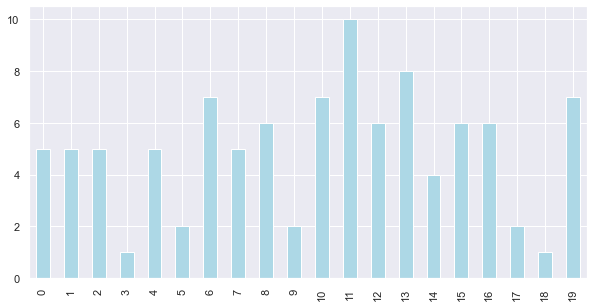

In [105]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

<AxesSubplot:>

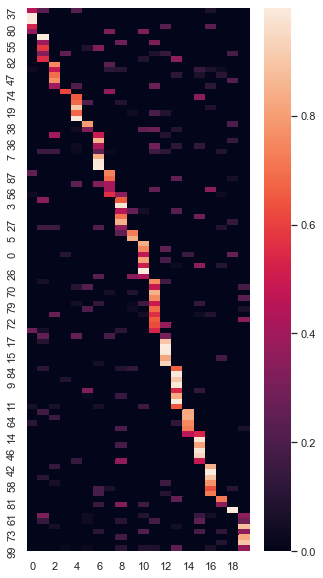

In [106]:
sns.set(rc={'figure.figsize':(5,10)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

In [274]:
#!pip install pyLDAvis

C:\Users\Philippine\Documents\ANACONDA\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [275]:
#!pip install --upgrade pandas==1.2

C:\Users\Philippine\Documents\ANACONDA\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
import pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [27]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))       
no_top_words = 5
display_topics(lda, vectorizer_X.get_feature_names(), no_top_words)

Topic 0:
instance home refer instal ideally
Topic 1:
dynamically code integer property multiple
Topic 2:
difference mvc aspnet join performance
Topic 3:
know believe instal analysis javascript
Topic 4:
pass function parameter string object
Topic 5:
file disable control copy index
Topic 6:
performance file xml need best
Topic 7:
process online understand count reference
Topic 8:
via random viewstate override bash
Topic 9:
developers mode echo dump advantage
Topic 10:
nod local flex open file
Topic 11:
visual studio build 2008 color
Topic 12:
version number automatically update settings
Topic 13:
array value number store assume
Topic 14:
100 height drop two break
Topic 15:
nod parameter programmer output throw
Topic 16:
graph data tree file line
Topic 17:
powershell unicode implement like rail
Topic 18:
however second equivalent disk slow
Topic 19:
null array return duplicate var
Topic 20:
attribute accept process javadoc easily
Topic 21:
different mobile useful calculate person
Topic 22